# <center> Sending and receiving a pulse demonstration

### <center> In this demo you will send and receive a pulse in loopback to demonstrate control over the QICK. 

By modifying the <code> config </code> Python dictionary in the below notebook cell, you can change several variables:
* The pulse length <code> length </code> in FPGA clock ticks (1 clock tick = 2.6 ns).
* The readout buffer length <code> readout_length </code> in FPGA clock ticks.
* The pulse envelope shape <code> pulse_style </code> (either <code> const </code> or <code> flat_top </code> or <code> arb </code>)
* The pulse amplitude <code> pulse_gain </code> in DAC units.
* The pulse frequency <code> pulse_freq </code> in MHz.
* The readout "time of flight" <code> adc_trig_offset </code> in FPGA clock ticks.
* The number of times you average the read <code> soft_avgs </code>

In [21]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.helpers import gauss
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/share/pynq-venv/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [22]:
# Load bitstream with custom overlay
# soc = QickSoc()
# soc = QickSoc(bitfile="../q3diamond/q3diamond.bit", force_init_clks=True)
soc = QickSoc(bitfile="q3diamond.bit", force_init_clks=True)
soc = QickSoc(bitfile="q3diamond.bit")
# soc = QickSoc(bitfile="q3diamond.bit",force_init_clks=True)
dac_locked = [soc.rf.dac_tiles[iTile].PLLLockStatus==2 for iTile in soc.dac_tiles]
adc_locked = [soc.rf.adc_tiles[iTile].PLLLockStatus==2 for iTile in soc.adc_tiles]
print(dac_locked, adc_locked)

# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
print(soccfg)


resetting clocks: 245.76 491.52
[True, True, True, True] [True]

QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v5 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v5 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_s

### misc
you don't have to run these three cells, they are just to demonstrate ways of directly accessing the readout and gen objects.

In [3]:
for gen in soc.gens:
    print(gen)
    if gen.HAS_MIXER:
        print(gen.get_mixer_freq())
    if hasattr(gen, 'get_freq'):
        print([gen.get_freq(i) for i in range(4)])

500.0000000000094
500.0000000000094
500.0000000000094
500.0000000000094
500.0000000000094
[0.0, 0.0, 0.0, 0.0]


for ro in soc.readouts:
    print(ro.get_freq())

In [4]:
for iq in soc.iqs:
    iq.set_iq(0,0)
    iq.set_mixer_freq(0)

### Waveform signal generators (signal_gen, sg_int4)
In these demos you can set res_ch to any signal generator that supports waveforms - either a signal_gen or an sg_int4.
If you use an sg_int4, you could also set the mixer_freq to a nonzero value.

Note the following:
* signal_gen_v5 has known problems with phase (it is not consistent shot-to-shot), and the generator always exhibits stdysel="last" behavior (i.e. the last clock's worth of waveform repeats forever, giving you a DC offset plus some RF - probably not what you want, this is normally only visible with the "const" pulse style).
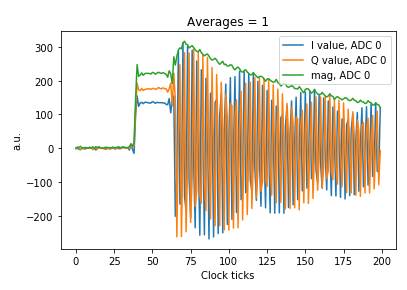
* Both signal_gen_v5 and sg_int4 seem to have glitches between flat_top pulse segments. With signal_gen_v5 these glitches are rare (1/100 shots?), and when this happens one segment has an entirely different phase from the next. With sg_int4 the glitches are always present, but only the samples at the segment boundaries are affected - maybe this is because the interpolation is rounding the envelopes off at the ends.

sg_int4:
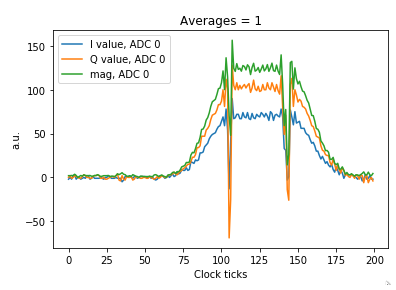

signal_gen_v5:
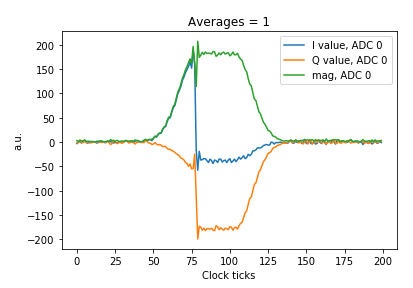


### sg_mux4
This will work on both old (four non-PFB readouts) and new (one PFB readout) firmwares.
With the old firmware, you'll need a splitter to wire the gen to all the readouts.

In [25]:
class MuxProgram(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        cfg=self.cfg   
        self.declare_gen(ch=cfg["res_ch"], nqz=1, mixer_freq=cfg["mixer_freq"], mux_freqs=cfg["pulse_freqs"], ro_ch=cfg["ro_chs"][0])
        for iCh, ch in enumerate(cfg["ro_chs"]): #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, freq=cfg["pulse_freqs"][iCh], length=cfg["readout_length"], gen_ch=cfg["res_ch"])

        self.set_pulse_registers(ch=cfg["res_ch"], style="const", length=cfg["length"], mask=[0,1,2,3])
        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger(adcs=self.ro_chs, pins=[0],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=self.cfg["res_ch"],t=0)

        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels

config={"res_ch":6, # --Fixed
        "mixer_freq":10.0, # MHz
        "ro_chs":[0,1,2,3], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":10, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "length":200, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":500, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_freqs": [100, 300, 500, 700], # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 50, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages
       }

###################
# Try it yourself !
###################

prog =MuxProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# print(prog)

  0%|          | 0/100 [00:00<?, ?it/s]

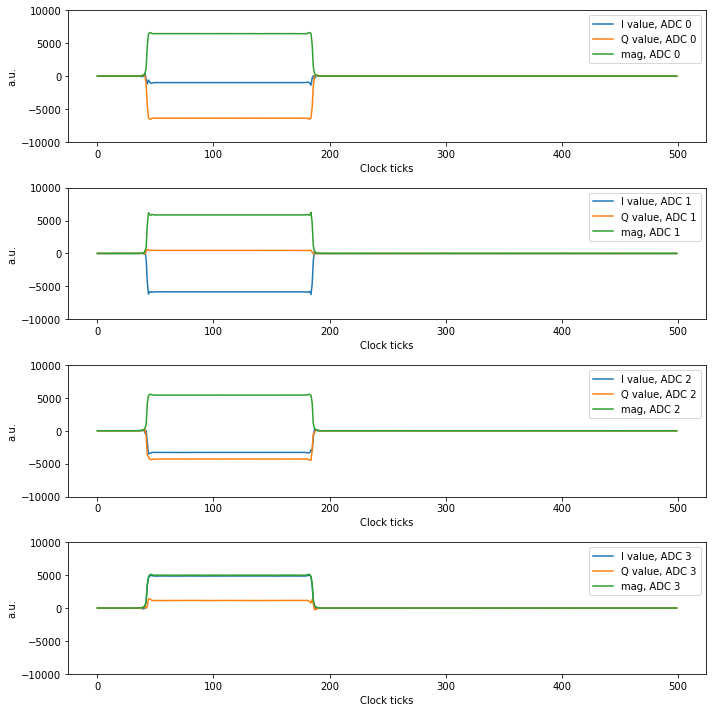

In [26]:
# Plot results.
fig, axs = plt.subplots(4,1,figsize=(10,10))

for ii, iq in enumerate(iq_list):
    plot = axs[ii]
    plot.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_ylim([-10000,10000])
    plot.set_xlabel("Clock ticks")
    #plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend()

plt.tight_layout()
    